In [1]:
import os
import sys
sys.path.append('..')

import mne
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import psychopy

In [2]:
DATA_DIR = '../data/pilots/test/'
EDF_FNAME = 'raw.asc'

## Calibration

In [3]:
cals_el_data = mne.preprocessing.eyetracking.read_eyelink_calibration(os.path.join(DATA_DIR, EDF_FNAME), screen_distance=70, screen_resolution=[1920,1080], screen_size=[.531, .298])

Reading calibration data from /Users/lollipop/projects/eyetracking_physics/notebooks/../data/pilots/test/raw.asc


In [4]:
cal_data = cals_el_data[0]

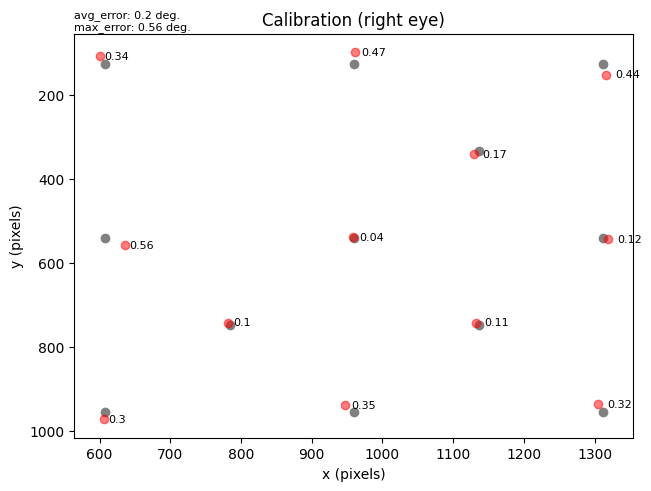

In [5]:
fig = cal_data.plot()

In [74]:
raw_el_data = mne.io.read_raw_eyelink(
    os.path.join(DATA_DIR, EDF_FNAME), create_annotations=True);

Loading /Users/lollipop/projects/eyetracking_physics/notebooks/../data/pilots/test/raw.asc
Pixel coordinate data detected.Pass `scalings=dict(eyegaze=1e3)` when using plot method to make traces more legible.
Pupil-size area detected.
There are 10 recording blocks in this file. Times between blocks will be annotated with BAD_ACQ_SKIP.


In [82]:
print(f'len of list: {len(list(raw_el_data.annotations))}')
filtered_data = []
beg_idx = 0
end_idx = 0
for idx,item in enumerate(list(raw_el_data.annotations)):
    if item['description'] == 'VIDEO_STIM_ONSET':
        beg_idx = idx
    if item['description'] == 'BUTTON_PRESS':
        filtered_data.append([x for x in raw_el_data.annotations][beg_idx:idx+1])

len of list: 163


In [99]:
set(list([x['description'] for x in raw_el_data.annotations]))

{'BAD_ACQ_SKIP',
 'BAD_blink',
 'BUTTON_PRESS',
 'VIDEO_STIM_ONSET',
 'fixation',
 'saccade'}

In [62]:
df = raw_el_data.to_data_frame()


In [95]:
df[df.time==0.556]

,time,xpos_right,ypos_right,pupil_right
556,0.556,886.9,333.7,1117.0


In [64]:
# We'll use xpos_right and ypos_right for this example
# Adjust column names if they're different in your dataframe
x = df['xpos_right']
y = df['ypos_right']

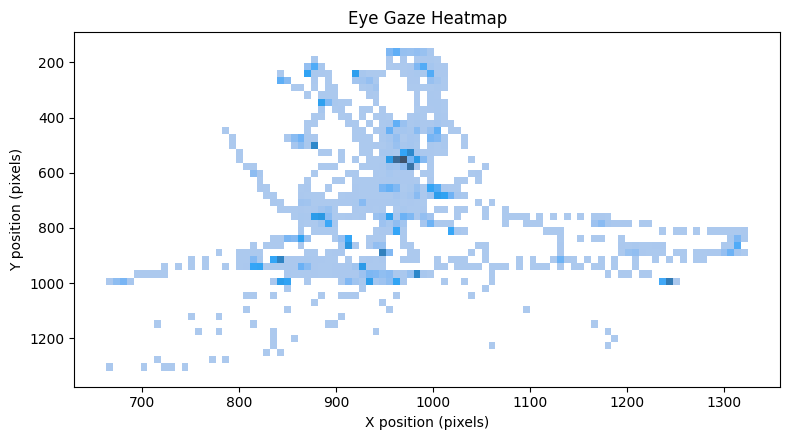

In [65]:
fig, ax = plt.subplots(figsize=(8, 4.5))
sns.histplot(data=df, x='xpos_right', y='ypos_right', ax=ax)
ax.set_xlabel('X position (pixels)')
ax.set_ylabel('Y position (pixels)')
ax.set_title('Eye Gaze Heatmap')
ax.invert_yaxis()
# ax.set_xlim(0, 1920)
# ax.set_ylim(1080, 0)
# plt.plot((1920/2-400, 1920/2+400), (1080/2+500, 1080/2+500), color = 'b')
# plt.plot((1920/2-400, 1920/2+400), (1080/2-500, 1080/2-500), color = 'b')
# plt.plot((1920/2+400, 1920/2+400), (1080/2-500, 1080/2+500), color = 'b')
# plt.plot((1920/2-400, 1920/2-400), (1080/2-500, 1080/2+500), color = 'b')
plt.tight_layout()

In [22]:
df

,time,xpos_right,ypos_right,pupil_right
0,0.000,965.1,558.0,1135.0
1,0.001,964.4,557.9,1135.0
2,0.002,964.3,558.1,1135.0
3,0.003,964.1,558.0,1135.0
4,0.004,964.1,558.2,1135.0
...,...,...,...,...
63999,63.999,996.5,441.4,1261.0
64000,64.000,996.6,440.4,1263.0
64001,64.001,996.8,439.4,1265.0
64002,64.002,997.1,438.3,1265.0


In [23]:
gaze_data_df = pd.read_json(os.path.join('../data/pilots/test_data.json'))

In [24]:
gaze_data_df = gaze_data_df.explode('gaze_data')

In [25]:
gaze_data_df[['time', 'x_pos', 'y_pos']] = pd.DataFrame(
    gaze_data_df.gaze_data.to_list(), index=gaze_data_df.index)
del gaze_data_df['gaze_data']

In [26]:
from psychopy.tools import monitorunittools
def convert(pos):
    return monitorunittools.convertToPix(
        [
            (0,0),(1920,0),(1920,1080),(0,1080)
        ], pos)

In [58]:
def transform_coords_psychopy_pixels(coord, x=True):
    if x:
        return (coord * 1920)/2 + (1920/2)
    return (coord * 1080)/2 + (1080/2)

In [59]:
def height2pix(coord, x=True):
    '''Converts height units to pixel units for a given window.
    
    Args:
        win: The display window.
        pos: The position.
    Returns:
        Adjusted position (x,y).
    '''
    if x:
        w = 1080 / 2  # eyetracker uses non-retina pixels
        h = 1920 / 2
        # Scale coordinate
        coord *= h
        # Center
        coord += w/2
    else:
        w = 1080 / 2  # eyetracker uses non-retina pixels
        h = 1920 / 2
        # scale and invert y
        coord *= -h
        # center
        coord +=  h/2
    return coord

In [60]:
gaze_data_df['x_pos_pix'] = gaze_data_df.x_pos.apply(
    lambda x: transform_coords_psychopy_pixels(x, True))
gaze_data_df['y_pos_pix'] = gaze_data_df.y_pos.apply(
    lambda y: transform_coords_psychopy_pixels(y, False))
gaze_data_df['x_pos_hpix'] = gaze_data_df.x_pos.apply(
    lambda x: height2pix(x, True))
gaze_data_df['y_pos_hpix'] = gaze_data_df.y_pos.apply(
    lambda y: height2pix(y, False))

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(data=gaze_data_df, x='y_pos_hpix', y='x_pos_hpix', ax=ax, hue='scene_name')
ax.set_xlabel('X position (pixels)')
ax.set_ylabel('Y position (pixels)')
ax.set_title('Eye Gaze Heatmap')
# ax.invert_yaxis()
# ax.invert_xaxis()
# ax.set_xlim(0, 1080)
# ax.set_ylim(1920, 0)
# plt.plot((1920/2-400, 1920/2+400), (1080/2+500, 1080/2+500), color = 'b')
# plt.plot((1920/2-400, 1920/2+400), (1080/2-500, 1080/2-500), color = 'b')
# plt.plot((1920/2+400, 1920/2+400), (1080/2-500, 1080/2+500), color = 'b')
# plt.plot((1920/2-400, 1920/2-400), (1080/2-500, 1080/2+500), color = 'b')
plt.tight_layout()

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x164671b40> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x1682d6cb0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

/Users/lollipop/miniconda3/envs/tracker/lib/python3.10/site-packages/seaborn/axisgrid.py:241: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/lollipop/miniconda3/envs/tracker/lib/python3.10/site-packages/seaborn/axisgrid.py:241: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/lollipop/miniconda3/envs/tracker/lib/python3.10/site-packages/seaborn/axisgrid.py:241: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/lollipop/min

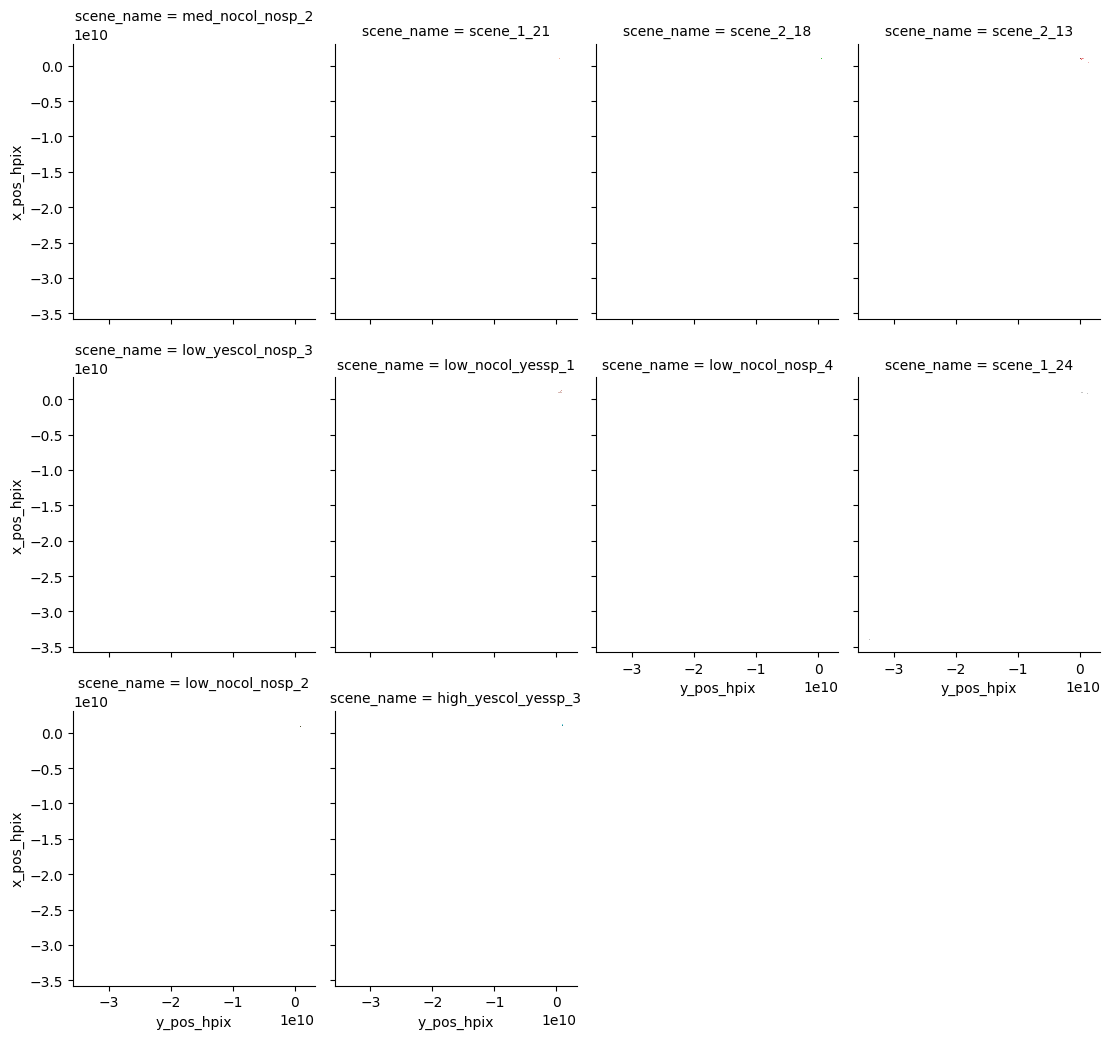

In [57]:
g = sns.FacetGrid(
    data=gaze_data_df,
    col="scene_name",
    hue='scene_name',
    height=3.5,
    aspect=800/1000,
    col_wrap=4)
g.map(sns.histplot, 'y_pos_hpix', 'x_pos_hpix')
# for ax in g.axes:
#     ax = ax.invert_yaxis()
plt.tight_layout()

In [108]:
with open('../data/pilots/test/raw.asc', 'r') as f:
    for line in f:
        # Process each line according to the file's structure
        # data = line.split('\n')  # Assuming comma-separated values
        if 'BUTTON_PRESS' in line or 'VIDEO_STIM_ONSET' in line:
            data = line
            print(data)

MSG	314291 VIDEO_STIM_ONSET

MSG	316617 BUTTON_PRESS

MSG	321565 VIDEO_STIM_ONSET

MSG	323181 BUTTON_PRESS

MSG	328969 VIDEO_STIM_ONSET

MSG	330847 BUTTON_PRESS

MSG	336124 VIDEO_STIM_ONSET

MSG	337697 BUTTON_PRESS

MSG	344282 VIDEO_STIM_ONSET

MSG	347133 BUTTON_PRESS

MSG	351241 VIDEO_STIM_ONSET

MSG	352814 BUTTON_PRESS

MSG	357392 VIDEO_STIM_ONSET

MSG	359496 BUTTON_PRESS

MSG	363166 VIDEO_STIM_ONSET

MSG	365315 BUTTON_PRESS

MSG	369753 VIDEO_STIM_ONSET

MSG	371213 BUTTON_PRESS

MSG	376111 VIDEO_STIM_ONSET

MSG	378116 BUTTON_PRESS

